# 프로젝트 : CIFAR-10 이미지 생성하기

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.
- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

# 1. 작업환경 구성
- $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples 

- $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints   

- $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history     


In [43]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 2. 데이터셋 구성
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [44]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 아래 코드는 참고만 하세요.

In [45]:
# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

In [46]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [47]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5)/127.5 #이미지 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


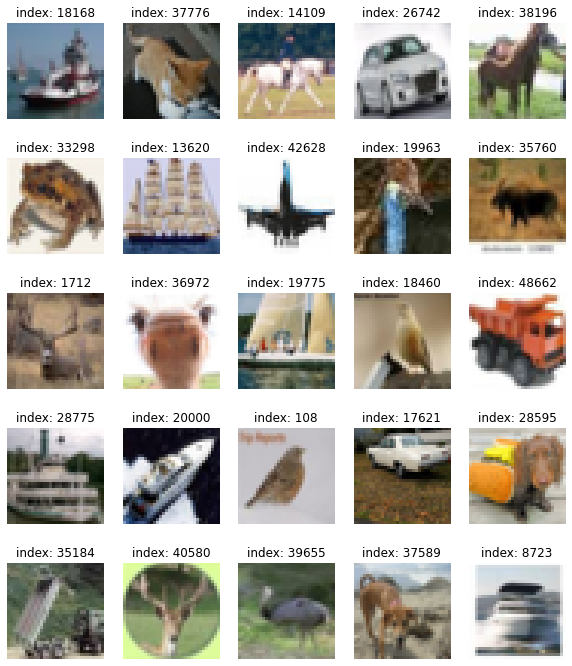

In [48]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [49]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [50]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(2*2*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, 1024)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [51]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 4, 4, 256)         6553600   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 256)        

In [52]:
noise = tf.random.normal([1, 100])

noise = tf.random.normal([1, 100])로 생성

In [53]:
generated_image = generator(noise, training=False)
generated_image[0].shape

TensorShape([32, 32, 3])

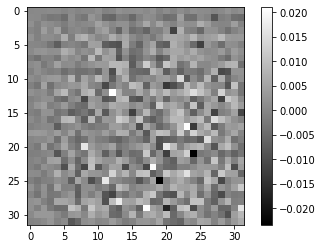

In [54]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# 4. 판별자 모델 구현
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [55]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5),  strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [56]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [57]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00038664]], dtype=float32)>

# 5. 손실함수와 최적화 함수
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [58]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [59]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [60]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [61]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [62]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

In [93]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 6. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [63]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [64]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    np_predictions = predictions.numpy()
    np_predictions = (np_predictions * 127.5) + 127.5 # 정규화 했던 것을 되돌리기
    np_predictions = np_predictions.astype(int)   
    
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [65]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10    # matlab 차트의 기본 크기를 15,10으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [66]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 7. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [69]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [86]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

첫 훈련 결과 gif를 아래쪽에 올렸으며     
해당 이미지는 epoch 500을 주고 난 뒤의 최종결과물이다.
약간은 꼬인듯 하다

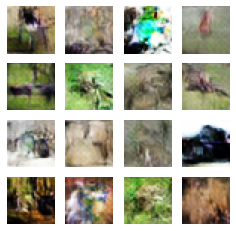

Time for training : 15319 sec


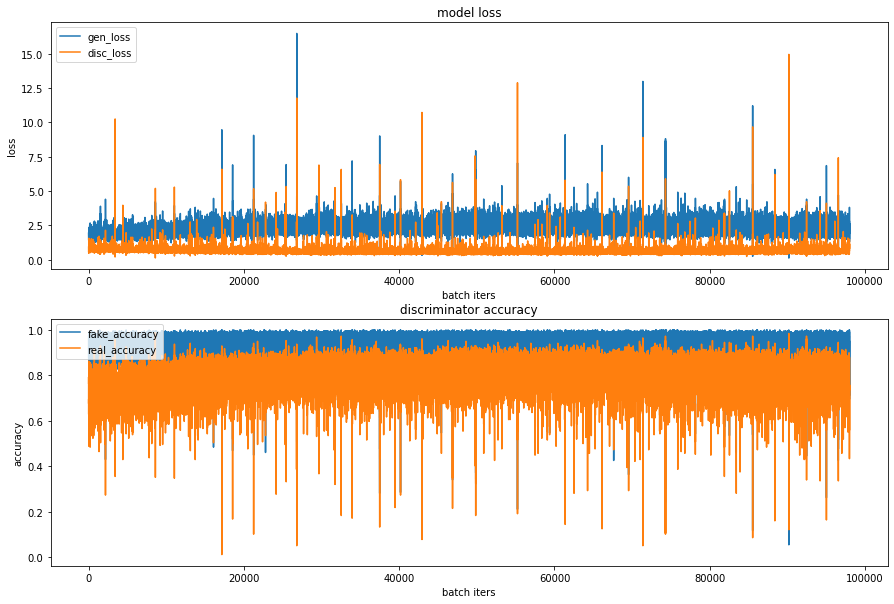

CPU times: user 4h 19min 44s, sys: 11min 29s, total: 4h 31min 14s
Wall time: 4h 15min 24s


In [87]:
%%time
train(train_dataset, EPOCHS, save_every)

In [90]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_02.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_02.gif

-rw-r--r-- 1 root root 2927930 Feb 15 07:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_02.gif


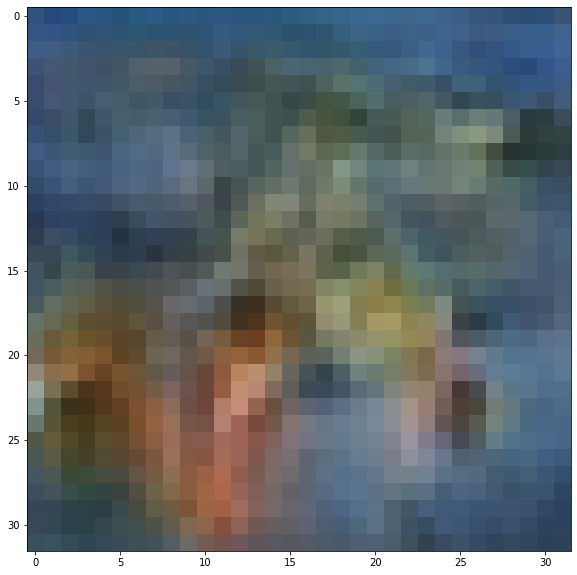

In [92]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

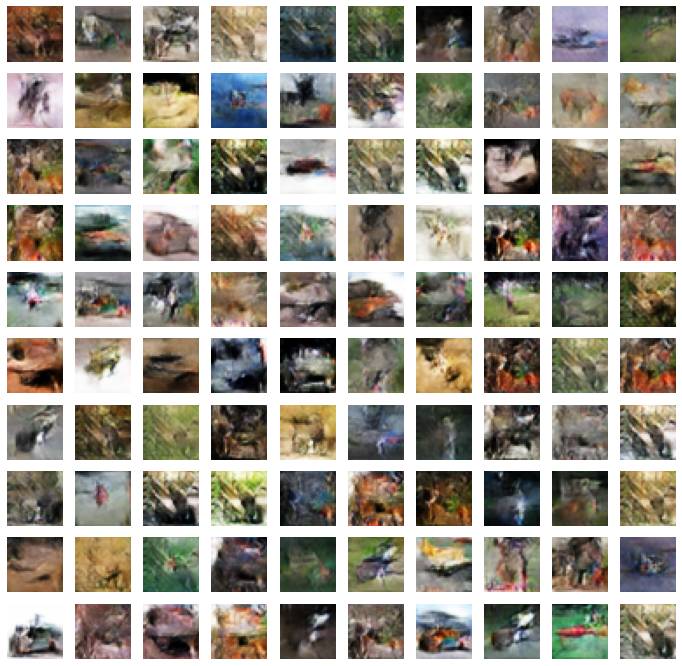

In [94]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints8'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 8. (optional) GAN 훈련 과정 개선하기
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628?gi=966d9d6689d6)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

초기훈련
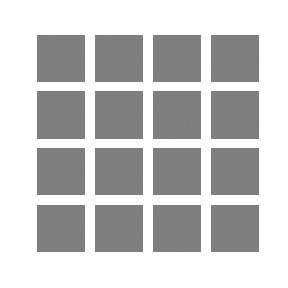
- 구분이 잘 안된다.
- 훈련량을 늘려야한다

Epoch 500을 주고 난 뒤의 gif 결과
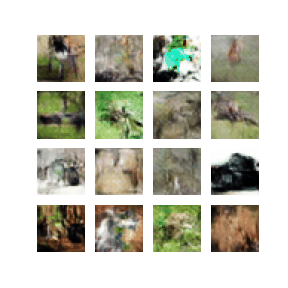

# 회고
- 첫 훈련에 비하면 많은 변화가 있었다.
- GAN이 이루어지는 개념자체가 재밌었으며, 실시간으로 에폭별 변화가 보여서 신기했다.
- 모델의 구조를 다르게 다양하게 많이 변경해봐야한다. 예를들면 batch_normalization이나 dropout의 위치를 바꾸거나 빼주거나 LeakyReLU의 alpha 값 조정 등의 많은 선택지가 있다.
